In [1]:
library(tidyverse)
library(readxl)
library(testthat)
library(digest)
library(repr)
library(tidymodels)
library(cowplot)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘testthat’


The following object is masked from ‘package:dplyr’:

    matches


The following object is masked from ‘package:purrr’:

    is_null


The following object is masked from ‘package:tidyr’:

    matches


Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────

In [2]:
set.seed(19)
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls"
download.file(url, "data/credit_default.xls")
cd <- read_excel("data/credit_default.xls", skip = 1)
head(cd)

ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,⋯,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,20000,2,2,1,24,2,2,-1,-1,⋯,0,0,0,0,689,0,0,0,0,1
2,120000,2,2,2,26,-1,2,0,0,⋯,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,90000,2,2,2,34,0,0,0,0,⋯,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,50000,2,2,1,37,0,0,0,0,⋯,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
5,50000,1,2,1,57,-1,0,-1,0,⋯,20940,19146,19131,2000,36681,10000,9000,689,679,0
6,50000,1,1,2,37,0,0,0,0,⋯,19394,19619,20024,2500,1815,657,1000,1000,800,0


In [3]:
colnames(cd) <- make.names(colnames(cd))
head(cd)

ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,⋯,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,20000,2,2,1,24,2,2,-1,-1,⋯,0,0,0,0,689,0,0,0,0,1
2,120000,2,2,2,26,-1,2,0,0,⋯,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,90000,2,2,2,34,0,0,0,0,⋯,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,50000,2,2,1,37,0,0,0,0,⋯,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
5,50000,1,2,1,57,-1,0,-1,0,⋯,20940,19146,19131,2000,36681,10000,9000,689,679,0
6,50000,1,1,2,37,0,0,0,0,⋯,19394,19619,20024,2500,1815,657,1000,1000,800,0


In [24]:
cd_university <- cd %>%
filter(EDUCATION == 2)
cd_university
nrow(cd_university)

ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,⋯,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,20000,2,2,1,24,2,2,-1,-1,⋯,0,0,0,0,689,0,0,0,0,1
2,120000,2,2,2,26,-1,2,0,0,⋯,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,90000,2,2,2,34,0,0,0,0,⋯,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,50000,2,2,1,37,0,0,0,0,⋯,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
5,50000,1,2,1,57,-1,0,-1,0,⋯,20940,19146,19131,2000,36681,10000,9000,689,679,0
8,100000,2,2,2,23,0,-1,-1,0,⋯,221,-159,567,380,601,0,581,1687,1542,0
13,630000,2,2,2,41,-1,0,-1,-1,⋯,6500,6500,2870,1000,6500,6500,6500,2870,0,0
14,70000,1,2,2,30,1,2,2,0,⋯,66782,36137,36894,3200,0,3000,3000,1500,0,1
22,120000,2,2,1,39,-1,-1,-1,-1,⋯,0,632,316,316,316,0,632,316,0,1


[1] 14030

In [4]:
set.seed(19)
rows <- sample(nrow(cd))
df <- cd[rows, ]
cd_5000 <- slice(df, 1:5000) %>%
rename(default_nm = default.payment.next.month) %>%
mutate(default_nm = as_factor(default_nm)) %>%
mutate(usage_cdt = ((BILL_AMT1 + BILL_AMT2 + BILL_AMT3 + BILL_AMT4 + BILL_AMT5 + BILL_AMT6)/6)/LIMIT_BAL) %>%
mutate(pmt = ((PAY_AMT1 + PAY_AMT2 + PAY_AMT3 + PAY_AMT4 + PAY_AMT5 + PAY_AMT6)/6)/LIMIT_BAL) %>%
mutate(diff_usage_pmt = usage_cdt - pmt)
cd_5000

d1 <- filter(cd_5000, default_nm == 1)

d0 <- filter(cd_5000, default_nm ==0)

ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,⋯,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default_nm,usage_cdt,pmt,diff_usage_pmt
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>
7677,40000,2,5,1,48,0,0,0,0,⋯,3292,1400,0,0,0,0,0,0.8269500000,0.019550000,0.8074000000
9910,50000,2,3,2,44,2,2,2,2,⋯,0,3500,2000,0,2000,2000,1,0.8676366667,0.031666667,0.8359700000
4483,20000,1,5,2,50,0,0,0,-1,⋯,1333,1000,780,0,0,0,0,0.4484083333,0.025941667,0.4224666667
23941,150000,1,1,1,32,0,0,-2,-1,⋯,0,0,1662,0,0,0,0,0.0185133333,0.001846667,0.0166666667
14674,120000,2,1,2,27,-1,-1,-1,-1,⋯,700,700,10673,2550,0,10000,0,0.0476263889,0.034198611,0.0134277778
19129,50000,2,3,1,45,0,0,0,0,⋯,1611,1700,1547,785,1000,888,0,0.5696166667,0.025103333,0.5445133333
4803,50000,1,2,2,41,0,0,0,0,⋯,1844,4562,667,847,700,655,0,0.6468033333,0.030916667,0.6158866667
22061,70000,2,3,2,28,2,2,2,2,⋯,0,2600,2000,1200,0,1500,0,0.3767452381,0.017380952,0.3593642857
14815,230000,2,1,2,29,-1,-1,-1,-1,⋯,318,725,2592,3198,4260,4944,0,0.0144949275,0.011621014,0.0028739130


In [ ]:
d1_ed <- d1 %>%
ggplot(aes(x=EDUCATION)) +
geom_bar() +
ggtitle("d1_ed")

d0_ed <- d0 %>%
ggplot(aes(x=EDUCATION)) +
geom_bar() +
ggtitle("d0_ed")

plot_grid(d0_ed, d1_ed)
#Education (1 = graduate school; 2 = university; 3 = high school; 4 = others)

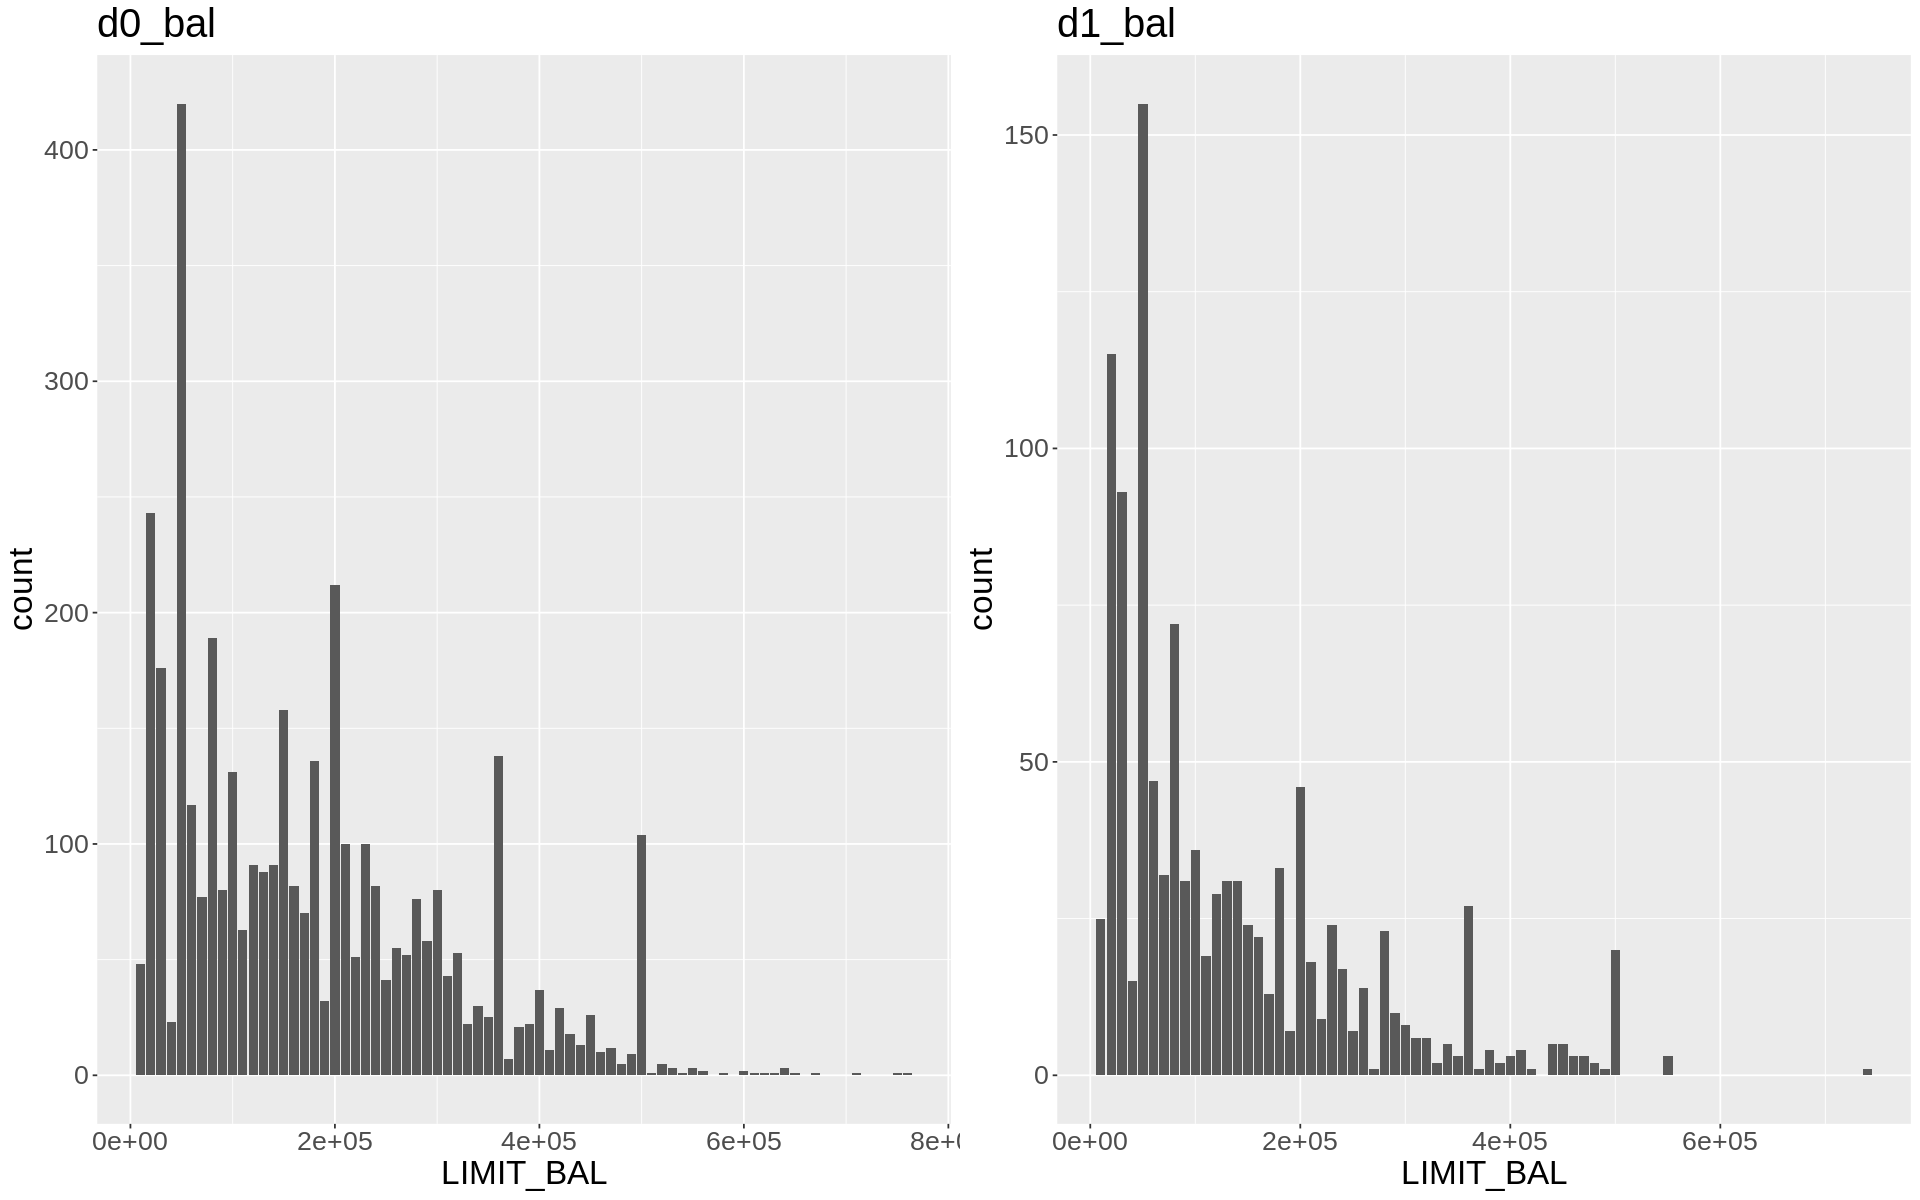

In [16]:
options(repr.plot.width = 16, repr.plot.height = 10)

d1_bal <- d1 %>%
ggplot(aes(x=LIMIT_BAL)) +
geom_bar() +
ggtitle("d1_bal") +

theme(text = element_text(size = 20))

d0_bal <- d0 %>%
ggplot(aes(x=LIMIT_BAL)) +
geom_bar() +
ggtitle("d0_bal") +
theme(text = element_text(size = 20))

plot_grid(d0_bal, d1_bal)

Don't know how to automatically pick scale for object of type function. Defaulting to continuous.

ERROR while rich displaying an object: Error: Aesthetics must be valid data columns. Problematic aesthetic(s): y = n. 
Did you mistype the name of a data column or forget to add after_stat()?

Traceback:
1. FUN(X[[i]], ...)
2. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
3. tryCatchList(expr, classes, parentenv, handlers)
4. tryCatchOne(expr, names, parentenv, handlers[[1L]])
5. doTryCatch(return(expr), name, parentenv, handler)
6. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[m

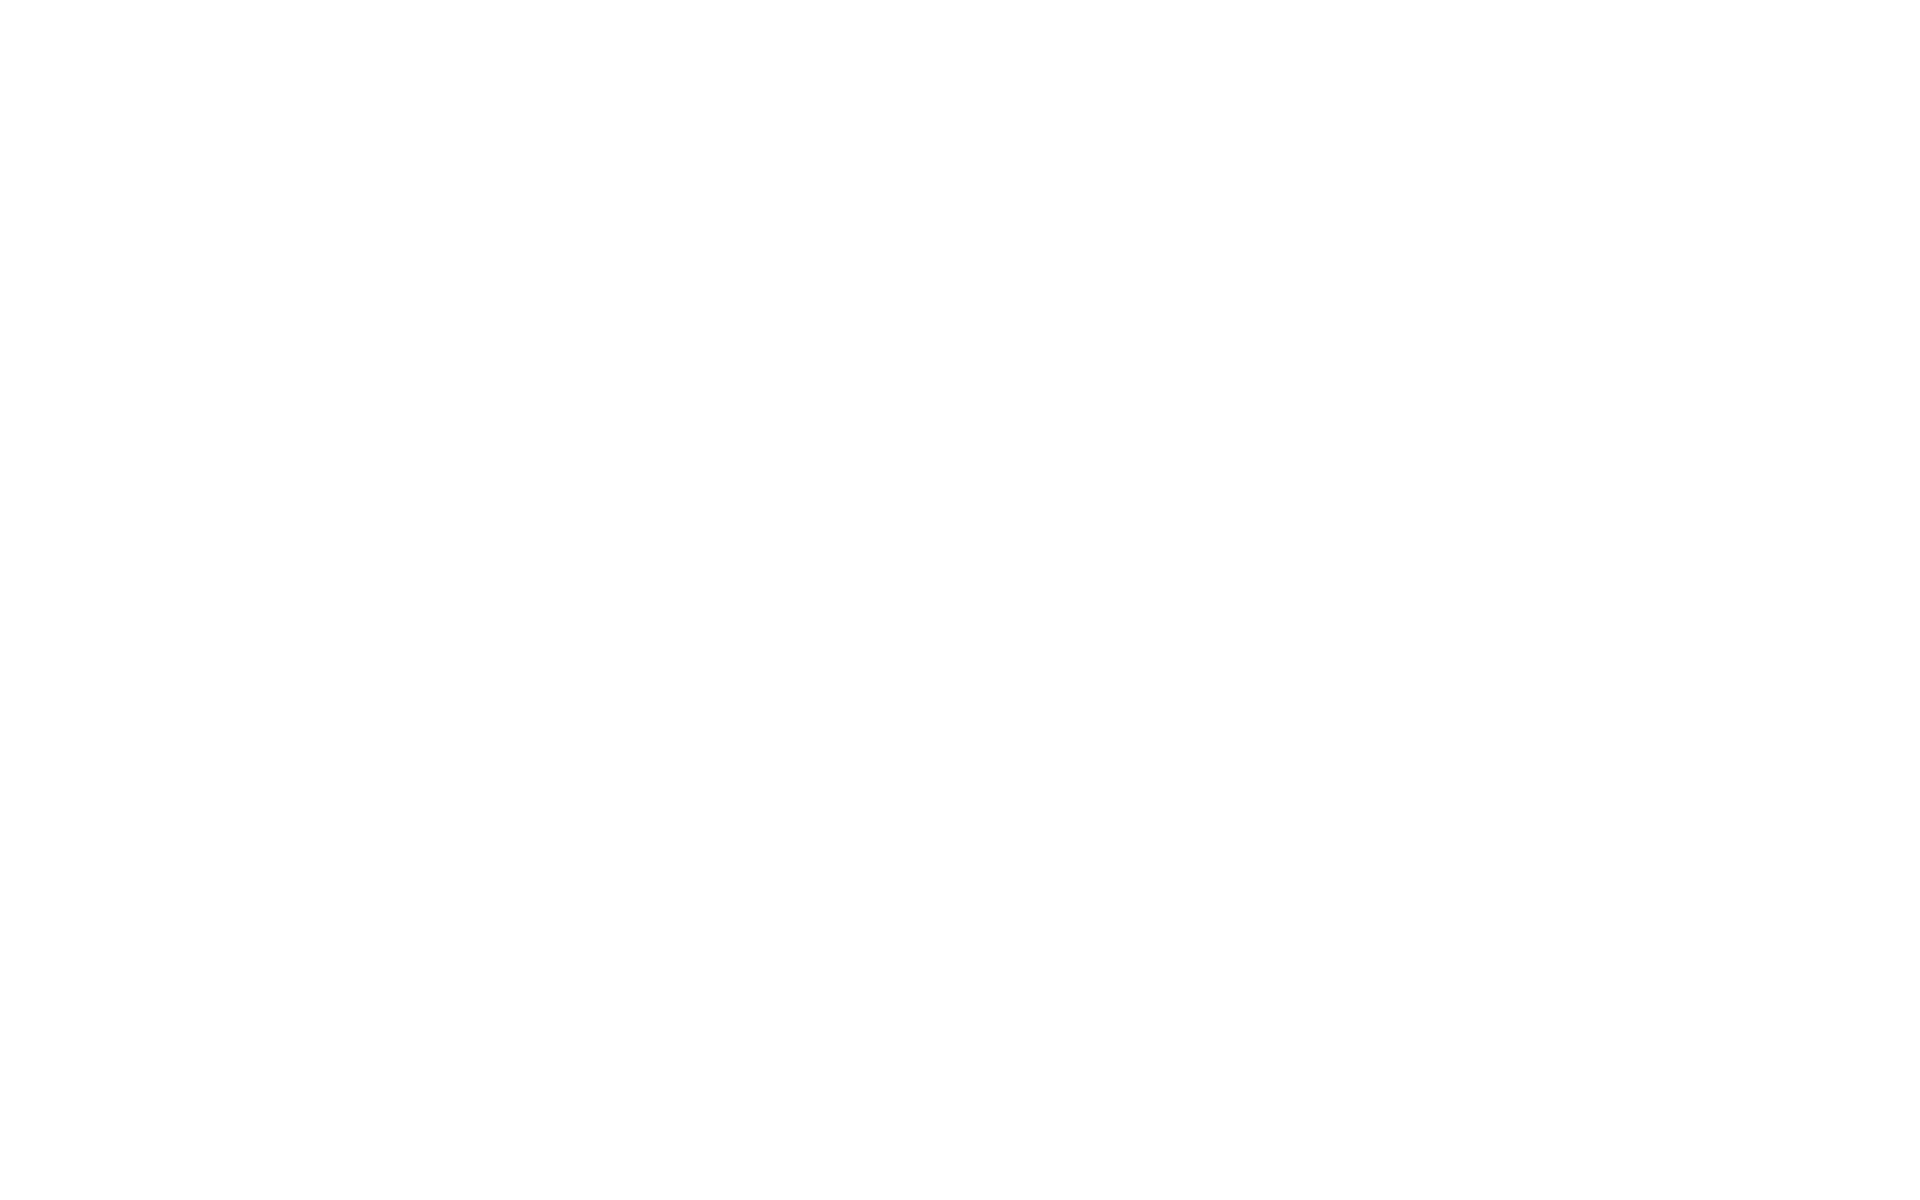

In [22]:
options(repr.plot.width = 16, repr.plot.height = 10)

limit_plot <- cd_5000 %>%
ggplot(aes(x=LIMIT_BAL, y=n, fill=default_nm)) +
geom_bar(stat="identity", position="fill")
limit_plot

In [ ]:
d1_mar <- d1 %>%
ggplot(aes(x=MARRIAGE)) +
geom_bar() +
ggtitle("d1_mar")

d0_mar <- d0 %>%
ggplot(aes(x=MARRIAGE)) +
geom_bar() +
ggtitle("d0_mar")

plot_grid(d0_mar, d1_mar)

In [ ]:
d0_pmt_usage <- d0 %>%
ggplot(aes(x=usage_cdt, y=pmt)) +
geom_point(alpha=0.4)

d1_pmt_usage <- d1 %>%
ggplot(aes(x=usage_cdt, y=pmt)) +
geom_point(alpha=0.4)

plot_grid(d0_pmt_usage, d1_pmt_usage, labels= c('d0_pmt_usage', 'd1_pmt_usage'))

In [ ]:
d0_diff <- d0 %>%
ggplot(aes(x=diff_usage_pmt, y=diff_usage_pmt)) +
geom_point(alpha=0.4)
d0_diff

d1_diff <- d1 %>%
ggplot(aes(x=diff_usage_pmt, y=diff_usage_pmt)) +
geom_point(alpha=0.4)
d1_diff

In [5]:
cd_split <- initial_split(cd_5000, prop=0.75, strata=default_nm)
cd_training <- training(cd_split)
cd_testing <- testing(cd_split)

In [ ]:
#cd_model <- glm(default_nm ~ LIMIT_BAL + EDUCATION + MARRIAGE + usage_cdt + pmt, data = cd_training, family = binomial(link="logit"))
#summary(cd_model)

In [ ]:
#cd_predictions <- predict(cd_model, cd_training, type="response")
#head(cd_predictions)

In [ ]:
#cd_predictions2 <- ifelse(cd_predictions > 0.5, 1, 0)
#cd_predictions2

In [6]:
cd_recipe <- recipe(default_nm ~ LIMIT_BAL + usage_cdt + pmt, data = cd_training) %>%
step_scale(all_predictors()) %>%
step_center(all_predictors())

cd_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
set_engine("kknn") %>%
set_mode("classification")


In [7]:
cd_vfold <- vfold_cv(cd_training, v=5, strata= default_nm)

grids <- tibble(neighbors = seq(1, 20))

cd_results <- workflow() %>%
add_recipe(cd_recipe) %>%
add_model(cd_spec) %>%
tune_grid(resamples = cd_vfold, grid=grids) %>%
collect_metrics()
cd_results

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.6867551,5,0.006144948,Model01
1,roc_auc,binary,0.5442490,5,0.007025027,Model01
2,accuracy,binary,0.6870221,5,0.005998287,Model02
2,roc_auc,binary,0.5763019,5,0.007762329,Model02
3,accuracy,binary,0.7355409,5,0.003643711,Model03
3,roc_auc,binary,0.5829332,5,0.007693242,Model03
4,accuracy,binary,0.7355409,5,0.003763711,Model04
4,roc_auc,binary,0.5869189,5,0.004789777,Model04
5,accuracy,binary,0.7462015,5,0.003680992,Model05


In [8]:
accuracies <- cd_results %>%
filter(.metric == 'accuracy')
accuracies

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.6867551,5,0.006144948,Model01
2,accuracy,binary,0.6870221,5,0.005998287,Model02
3,accuracy,binary,0.7355409,5,0.003643711,Model03
4,accuracy,binary,0.7355409,5,0.003763711,Model04
5,accuracy,binary,0.7462015,5,0.003680992,Model05
6,accuracy,binary,0.7464682,5,0.003674923,Model06
7,accuracy,binary,0.7597972,5,0.003539514,Model07
8,accuracy,binary,0.7587306,5,0.003190616,Model08
9,accuracy,binary,0.7613980,5,0.004326589,Model09


Warning message:
“Removed 2 rows containing missing values (geom_point).”
Warning message:
“Removed 2 row(s) containing missing values (geom_path).”


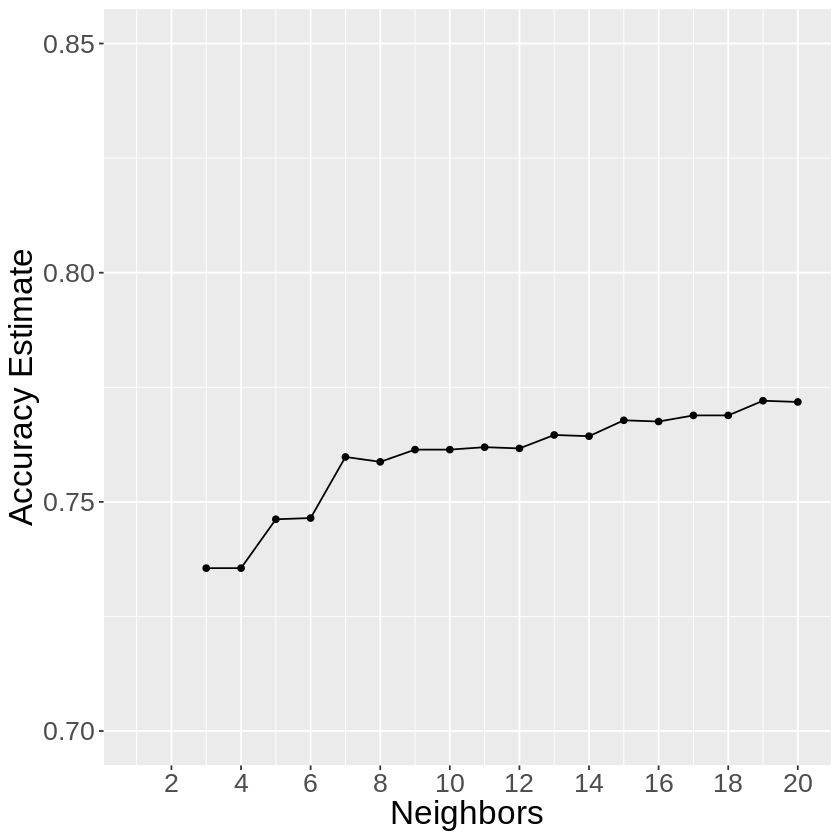

In [9]:
cross_val_plot <- ggplot(accuracies, aes(x=neighbors, y=mean)) +
geom_point() +
geom_line() +
labs(x="Neighbors", y="Accuracy Estimate") +
theme(text = element_text(size = 20)) +
                  scale_x_continuous(breaks = seq(0, 20, 2)) +
                  scale_y_continuous(limits = c(0.7, 0.85))
cross_val_plot